**Классификация негативных комментариев**

**Подготовка данных**

*Импорт библиотек*

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%pip install seaborn
import nltk
import re
from tqdm import tqdm
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
!pip install catboost
from catboost import CatBoostClassifier
from nltk.corpus import words
from pymystem3 import Mystem
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



# Загрузка и знакомство с данными

In [2]:
df = pd.read_excel('/content/М.Тех_ТЗ_Датасет_DS_NLP.xlsx')
df_backup = pd.read_excel('/content/М.Тех_ТЗ_Датасет_DS_NLP.xlsx')
display(df)
df.info()

,Unnamed: 0,id,text,class
0,0,45,негатив к вам и горячей линии которые нафиг н...,Консультация КЦ
1,1,97,перестаньте впаривать клиентам дополнительные ...,Компетентность продавцов/ консультантов
2,2,105,продавец предложил наклеить защитную плёнку з...,Компетентность продавцов/ консультантов
3,3,127,продавец режил продать нам товар почему то по ...,Компетентность продавцов/ консультантов
4,4,130,навязанные услуги ( без моего согласия) на сум...,Компетентность продавцов/ консультантов
...,...,...,...,...
2832,2832,17570,почему отключили электронную очередь через пол...,Электронная очередь
2833,2833,17579,очередь на кассе. продавцы не торопятся с зака...,Время ожидания у кассы
2834,2834,17586,"профессионализма менеджеру бы, да и внимания к...",Обслуживание продавцами/ консультантами
2835,2835,17591,сотрудник на выдаче заказа потребовал документ...,Электронная очередь


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2837 entries, 0 to 2836
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2837 non-null   int64 
 1   id          2837 non-null   int64 
 2   text        2837 non-null   object
 3   class       2837 non-null   object
dtypes: int64(2), object(2)
memory usage: 88.8+ KB


In [3]:
df.shape

(2837, 4)

In [4]:
df.head()

,Unnamed: 0,id,text,class
0,0,45,негатив к вам и горячей линии которые нафиг н...,Консультация КЦ
1,1,97,перестаньте впаривать клиентам дополнительные ...,Компетентность продавцов/ консультантов
2,2,105,продавец предложил наклеить защитную плёнку з...,Компетентность продавцов/ консультантов
3,3,127,продавец режил продать нам товар почему то по ...,Компетентность продавцов/ консультантов
4,4,130,навязанные услуги ( без моего согласия) на сум...,Компетентность продавцов/ консультантов


In [5]:
print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 0


*Посмотрим на распределение классов*

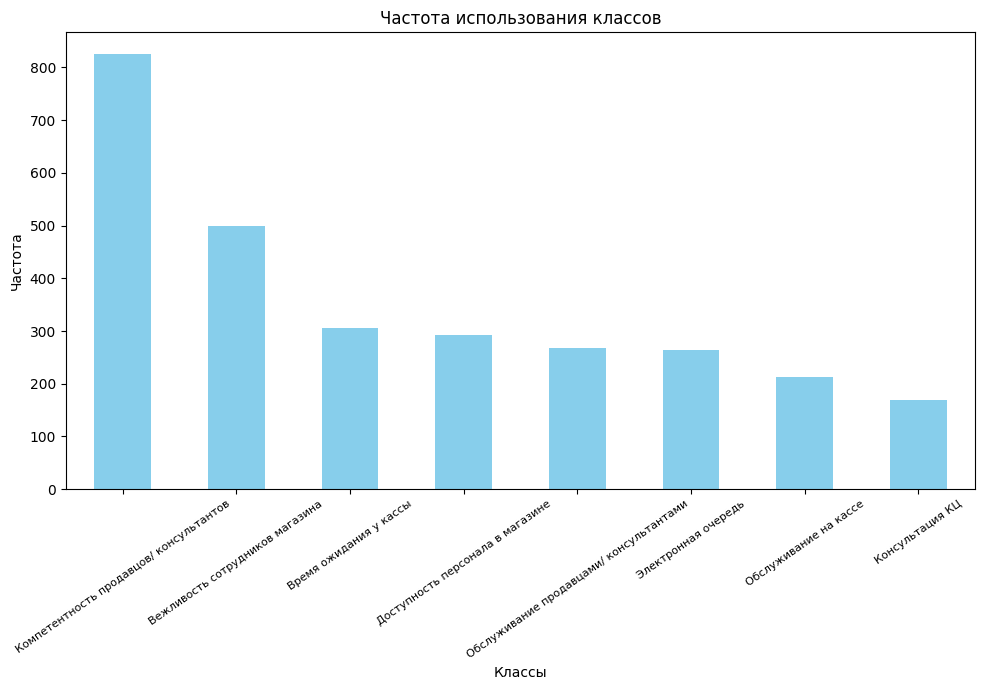

In [6]:
# Подсчет количества уникальных значений в столбце 'class'
class_counts = df['class'].value_counts()

# Создание графика
plt.figure(figsize=(10, 7))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Частота использования классов')
plt.xlabel('Классы')
plt.ylabel('Частота')
plt.xticks(fontsize=8)
plt.xticks(rotation = 35)
plt.tight_layout()
plt.show()

In [7]:
print(class_counts)

Компетентность продавцов/ консультантов    825
Вежливость сотрудников магазина            500
Время ожидания у кассы                     306
Доступность персонала в магазине           293
Обслуживание продавцами/ консультантами    267
Электронная очередь                        264
Обслуживание на кассе                      212
Консультация КЦ                            170
Name: class, dtype: int64


*Проверим, все ли отзывы клиентов написаны на русском языке*

In [8]:
nltk.download('words')

english_words = set(words.words())

def has_english_words(text):
    words_in_text = text.split()
    for word in words_in_text:
        if word.lower() in english_words:
            return True
    return False

df['has_english'] = df['text'].apply(has_english_words)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [9]:
if df['has_english'].any():
    print("Есть хотя бы одно значение True в колонке")
else:
    print("Нет значений True в колонке")

Есть хотя бы одно значение True в колонке


In [10]:
filtered_texts = df[df['has_english'] == True]['text']
print(filtered_texts)

184     сотрудник дал не верную информацию по apple tv...
627     очень сожалею что обратился к вам 25.12.2022 п...
670     добрый день. хотел купить в рассрочку планшет ...
685     расна терминале талон по выдаче интернет заказ...
940     консультант ввел в заблуждение и продал неподх...
1027    мне не понравилось , что на кассе меня запутал...
1040    отвратительная работа. товар не соответствует ...
1083    отвратительная работа сотрудников call center....
1084    просьба вернуть мне деньги за наушники, т к оп...
1486    сотрудники выдавшие заказ, были мягко сказать ...
1728    товар хороший. покупал раньше. повторил заказ....
2127    добрый день.  дважды общался с операторами кол...
2155    ужасное качество обслуживания. сотрудники инте...
2445    пришел в 10 утра забирать заказ, с кассовой зо...
2541    как обычно: эл очередь живет отдельно от выдач...
Name: text, dtype: object


*Так как среди комментариев есть иностранные символы - очистим набор данных от них, специальных символов и заглавных букв*

*Очистим датафрейм от специальных символов, заглавных букв и разделителей строк*



In [11]:
def cleaning(text):
    # Удаляем переводы строк
    text = re.sub(r"(?:\n|\r)", " ", text)
    # Удаляем спецсимволы и цифры, оставляем только русские и английские буквы
    text = re.sub(r"[^a-zA-Zа-яА-Я\s]", '', text)
    # Приводим к нижнему регистру
    text = text.lower()
    return text

df['text'] = df['text'].apply(cleaning)
print(df.head(20))

    Unnamed: 0   id                                               text  \
0            0   45   негатив к вам и горячей линии которые нафиг н...   
1            1   97  перестаньте впаривать клиентам дополнительные ...   
2            2  105   продавец предложил наклеить защитную плнку за...   
3            3  127  продавец режил продать нам товар почему то по ...   
4            4  130  навязанные услуги  без моего согласия на сумму...   
5            5  168  оператор проигнорировала информацию об ошибке ...   
6            6  181  сотрудник мало того что задал вопросы по повод...   
7            7  206  электронные талоны в приложении не работают пр...   
8            8  221        приложение не работало чтобы получить талон   
9            9  224  хотели оформить заказ через приложениено сотру...   
10          10  230  продавцами  нет отдали товар и не предложили в...   
11          11  241       консультантов в зале надо искать с собаками    
12          12  250   приехала продавц

*Добавим кодировку классов как дополнительный признак*

In [12]:
df['class_id'] = df['class'].factorize()[0]
df['class_id'].value_counts()

1    825
4    500
7    306
3    293
6    267
2    264
5    212
0    170
Name: class_id, dtype: int64

In [13]:
class_id_data = df[['class', 'class_id']].drop_duplicates().sort_values('class_id')

# Словарь для сверки id классов
class_to_id = dict(class_id_data.values)
id_to_class = dict(class_id_data[['class_id', 'class']].values)

id_to_class

{0: 'Консультация КЦ',
 1: 'Компетентность продавцов/ консультантов',
 2: 'Электронная очередь',
 3: 'Доступность персонала в магазине',
 4: 'Вежливость сотрудников магазина',
 5: 'Обслуживание на кассе',
 6: 'Обслуживание продавцами/ консультантами',
 7: 'Время ожидания у кассы'}

*Приступим к лемматизации текста*

In [14]:
mystem = Mystem()

def lemmatize_text(text):
    # Лемматизация текста с помощью Mystem
    lemmas = mystem.lemmatize(text)
    # Объединение лемм в строку и удаление лишних символов
    processed_text = ''.join(lemmas).replace(' \n', '').strip()
    return processed_text

# Применение лемматизации к столбцу 'text'
df['lemmatized_text'] = df['text'].apply(lemmatize_text)
print(df)

      Unnamed: 0     id                                               text  \
0              0     45   негатив к вам и горячей линии которые нафиг н...   
1              1     97  перестаньте впаривать клиентам дополнительные ...   
2              2    105   продавец предложил наклеить защитную плнку за...   
3              3    127  продавец режил продать нам товар почему то по ...   
4              4    130  навязанные услуги  без моего согласия на сумму...   
...          ...    ...                                                ...   
2832        2832  17570  почему отключили электронную очередь через пол...   
2833        2833  17579  очередь на кассе продавцы не торопятся с заказ...   
2834        2834  17586  профессионализма менеджеру бы да и внимания к ...   
2835        2835  17591  сотрудник на выдаче заказа потребовал документ...   
2836        2836  17594                           клиентоориентированность   

                                        class  has_english  cla

*Удалим ненужные колонки*

In [15]:
df.columns

Index(['Unnamed: 0', 'id', 'text', 'class', 'has_english', 'class_id',
       'lemmatized_text'],
      dtype='object')

In [16]:
df = df.drop(['id', 'Unnamed: 0','text','has_english'], axis=1)

df.columns

Index(['class', 'class_id', 'lemmatized_text'], dtype='object')

In [17]:
target = df['class']
features = df.drop(['class'], axis=1)
stopwords = stopwords.words('english')

features_train, features_test, target_train, target_test=train_test_split(df, target,test_size=0.1,random_state=42)

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['lemmatized_text'])
features_test = count_tf_idf.transform(features_test['lemmatized_text'])

print(features_train.shape)
print(features_test.shape)

(2553, 6127)
(284, 6127)


In [18]:
cv_counts = 10
model = LogisticRegression(class_weight='balanced')
scorer = make_scorer(f1_score, average='weighted')

train_f1_balanced = cross_val_score(model,
                                    features_train,
                                    target_train,
                                    cv=cv_counts,
                                    scoring=scorer).mean()
print('F1 на CV с балансированными классами', train_f1_balanced)

F1 на CV с балансированными классами 0.7955575609067231


**Итог первого этапа**

На данном этапе мы ознакомились с данными, узнали их тип, общее количество строк. Проверили на дубликаты, очистили данные от специальных символов, заглавных букв и разделителей строк, а затем провели лемматизацию текста. Выявили дисбаланс классов, ресемплировали данные и высчитали предварительную F1 меру с помощью кроссвалидации.

**Обучение**

In [21]:
%%time
# Создание пайплайна с моделью LogisticRegression
pipe = Pipeline([
    ('model', LogisticRegression(random_state=42, solver='liblinear', max_iter=1000))
])
# Создание параметров для GridSearchCV
param_grid = [
    {
        'model__penalty': ['l1', 'l2'],
        'model__C': list(range(1, 15, 3))
    }
]

# Создание метрики f1_weighted с помощью make_scorer
scorer = make_scorer(f1_score, average='weighted')

# Создание объекта GridSearchCV с указанием метрики scorer
grid = GridSearchCV(pipe, param_grid=param_grid, scoring=scorer, cv=cv_counts, verbose=True, n_jobs=-1)

# Обучение модели
best_grid = grid.fit(features_train, target_train)

print('Лучшие параметры:', grid.best_params_)
print('Лучшая метрика (F1 weighted):', grid.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Лучшие параметры: {'model__C': 10, 'model__penalty': 'l1'}
Лучшая метрика (F1 weighted): 0.7846524449384404
CPU times: user 5.41 s, sys: 1.16 s, total: 6.57 s
Wall time: 9min 21s


In [22]:
# Получение предсказаний на тестовых данных
predicted = best_grid.predict(features_test)

# Вычисление confusion matrix
cm = confusion_matrix(target_test, predicted)
print(cm)

[[38  0  1 13  0  1  1  2]
 [ 0 23  0  0  0  1  0  0]
 [ 0  0 26  3  0  1  0  0]
 [ 4  2  2 77  1  0  6  1]
 [ 0  0  0  2 21  0  0  0]
 [ 6  0  0  2  0  6  3  0]
 [ 1  0  3  4  0  0  8  0]
 [ 0  0  0  2  0  1  0 22]]


In [24]:
# Создание и обучение модели RandomForestClassifier
rfc_model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)
rfc_model.fit(features_train, target_train)

# Предсказание на тестовом наборе данных
y_pred = rfc_model.predict(features_test)

# Рассчет F1-меры
f1 = f1_score(target_test, y_pred, average='weighted')
print("F1-score:", f1)

F1-score: 0.16875112376385976


In [25]:
df = df.sample(frac=1)
df.head()

,class,class_id,lemmatized_text
1107,Компетентность продавцов/ консультантов,1,не компетентный не внимательный и не знающий с...
1112,Обслуживание продавцами/ консультантами,6,сотрудник озеров сергей быть не приветливый и ...
2594,Консультация КЦ,0,ваш сотрудник когда звонить для актуальность з...
387,Вежливость сотрудников магазина,4,охранник отпугивать сразу и всемxd
206,Компетентность продавцов/ консультантов,1,не навязывать дополнительный услуга на который...


In [ ]:
%%time
params_forest = {
    'n_estimators': list(range(50,500,50)),
    'max_depth':[3,15],
    'max_features' : list(range(1,20, 2))
}


model = RandomForestClassifier(random_state=42)

grid = GridSearchCV(model, param_grid=params_forest, scoring='f1', cv=10, verbose=True, n_jobs=-1)
best_grid = grid.fit(features_train, target_train)
print('Лучшие параметры:', grid.best_params_)
print('Лучшая метрика:', grid.best_score_)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
